In [2]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Image

from vis_common import load_store, load_games
import winrate

FS = (10, 6) # Reasonable default figsize
QUANTILES = [0, .25, .5, .7, .85, .95, 1.]
QUANTILE_LABELS = ['0-25%', '25-50%', '50-70%', '70-85%', '85-95%', '95-100%']


store = load_store()
g = games = load_games()
g['wr'] = winrate.smoothed_winrate(g)
g['quantile'] = pd.qcut(g['wr'], q=QUANTILES, labels=QUANTILE_LABELS)

A "newbie trap" is an ill-advised gameplay decision that inexperienced players are likely to make because they don't know any better. 

For example, before version 0.14, the entrance to the Orcish Mines would appear between levels 6-11 of the dungeon - on average, earlier than the less-deadly Lair of Beasts. Experienced players (and those who read walkthrough guides) knew to look for the lair first, and backtrack to the mines later. Newbs would go straight into the mines and get crushed.

In this post, I'll try to use data to test the validity of some putative newbie traps.

## Methodology

(Details for nerds - feel free to skip)

I assigned each player a smoothed winrate estimate - see [this post](TODO) for more details.

I associated with each game the winrate estimate of the player, and then partitioned the games according to quantiles of the smoothed winrate. 

For each 'trap', I'll be comparing these slices, either all simultaneously, or pitting some of the bottom range against the top (e.g. the bottom 25% vs. the top 10%).

A few technical notes:

- Yeah, the quantiles aren't evenly distributed. There's more interesting variation at the top.
- The quantiles are calculated with respect to the set of games, not players. The "0-25%" quantile bounds the bottom quarter of games (measured by player winrate), not the bottom 25% of players. (It was just a little simpler to do this way. Also, doing player quantiles would have exacerbated the asymmetry, since the top 10% of games by winrate were played by the top ~3% of players).


In [3]:
ppq = g.groupby('quantile').apply(lambda gr: len(gr['pid'].unique())).rename('# players')
gpq = g.groupby('quantile').size().rename('# games')
print pd.concat([ppq, gpq], axis=1)

          # players  # games
quantile                    
0-25%           533   331625
25-50%         2336   332180
50-70%         5579   264832
70-85%        16242   198965
85-95%          618   132792
95-100%         696    65768


## Mutation roulette

Are newbs more likely to optimistically quaff potions of mutation, or eat mutagenic meat, hoping for some beneficial mutations?

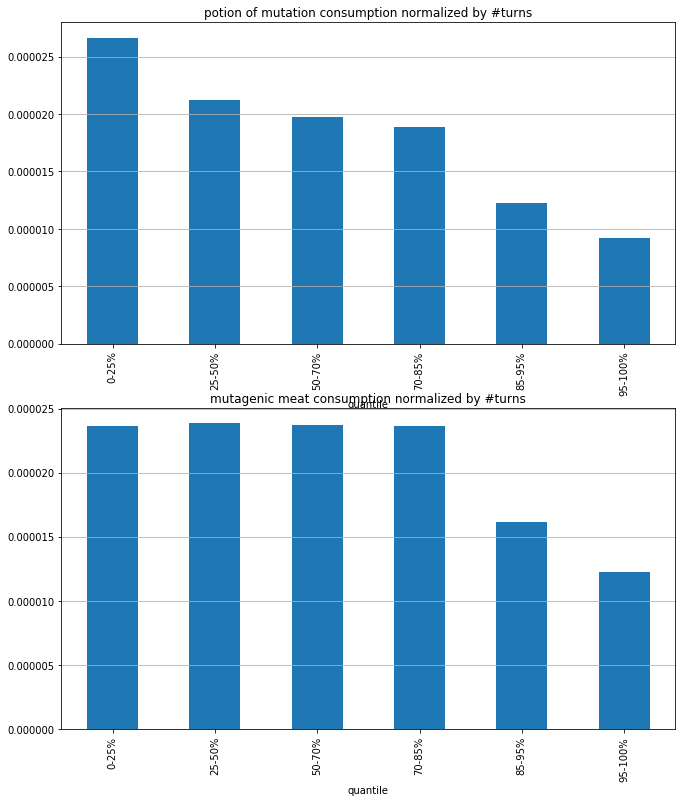

In [5]:
m = store['mutations']

fig, axes = plt.subplots(nrows=2, figsize=(11,13))
for (src, ax) in zip(['potion of mutation', 'mutagenic meat'], axes.flatten()):
    g['muts'] = m[(m['source']==src)]\
        .groupby(['gid', 'turn'], as_index=False).agg(lambda x: 1)\
        .groupby('gid').size()
    g['muts'].fillna(0, inplace=True)

    g.groupby('quantile')[['muts', 'turns']]\
        .apply(lambda x: x['muts'].sum() / x['turns'].sum())\
        .plot.bar(ax=ax, title='{} consumption normalized by #turns'.format(src))
    ax.grid(axis='y');

(Each bar corresponds to a subset of games grouped by player "talent" (= smoothed win rate estimate). 0-25% is the bottom quarter, 95-100% is the top 5%)

Seems like a pretty clear trend! The top 5% of games in particular involve half as much mutagen consumption per turn as the bottom half. 

On average, the games on the far right are lasting a lot longer than the ones on the left. If all players liked to quaff a bunch of mutations early on and never again after, then normalizing by number of turns would have the effect of making longer games seem less mutation-happy.

Just to be safe, let's control for this. I'll fix some turn count N, and ask: of the games that last at least N turns, how many potions of mutation are quaffed before turn N?

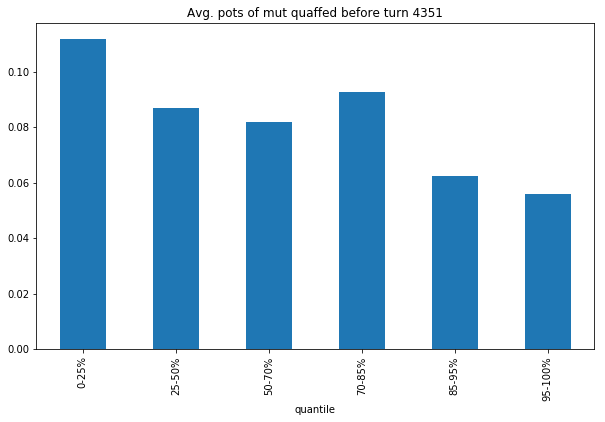

In [6]:
# Alternative metric: of games lasting at least N turns, avg. number of 
# mut pots quaffed before turn N?
turn_thresh = 4351 # Median quaff turn

mutquaffs = m[(m['source']=='potion of mutation') & (m['turn'] <= turn_thresh)]\
    .groupby(['gid', 'turn'], as_index=False).agg(lambda x: 1)\
    .groupby('gid').size()
g['muts'] = mutquaffs
g['muts'].fillna(0, inplace=True)

g[g['turns'] > turn_thresh].groupby('quantile')['muts']\
    .apply(lambda x: x.sum() / len(x) )\
    .plot.bar(figsize=FS, 
              title="Avg. pots of mut quaffed before turn {}".format(turn_thresh)
             );

**Verdict:**

In [7]:
Image(url='/assets/dcss/trap.png')

## Spellcasting overinvestment

A thread in the Tavern asks [Why do new players invest so many XP into spellcasting?](https://crawl.develz.org/tavern/viewtopic.php?f=17&t=19396), pointing to a CiP post as an example. Some suggest it's because newbs don't understand what the skill does, or that automatic XP assignment tends to favour it. Others are skeptical about whether this is truly a newbish trait.

Let's look at Spellcasting investment specifically among deep elf wizards (to control for aptitudes and starting skills).

In [8]:
sk = store['skill_progression']

def skill_progression(group, skill='spellcasting', max_level=28):
    return sk[(sk['skill']==skill) & sk['gid'].isin(group.index)]\
        .groupby('lvl')['xl']\
        .mean().reindex(pd.Index(range(max_level)))
    
quant_groups = [['0-25%', '25-50%'], ['85-95%', '95-100%']]
quant_labels = ['bottom 50%', 'top 15%']
def quant_group(label):
    q = g.loc[label, 'quantile']
    if q in quant_groups[0]:
        return 0
    elif q in quant_groups[1]:
        return 1
    
def plot_progress(sps, bgs, skill='spellcasting', max_skill=28, 
                  transpose=False, ax=None, min_games=5):
    for qg in quant_groups:
        relevant_games = g[(g['species'].isin(sps)) & (g['bg'].isin(bgs)) 
                           & g['quantile'].isin(qg)]
        games_per_lvl = sk[(sk['skill']==skill) & sk['gid'].isin(relevant_games.index)]\
            .groupby('lvl').size()
        toosmall = (games_per_lvl < min_games)
        if toosmall.any():
            # idquitek what's going on here
            if toosmall.all():
                raise Exception("Not enough games")
            first_bigenough = toosmall.argmin()
            am = toosmall[first_bigenough:].argmax()
            max_skill = min(max_skill, am)
    
    #max_skill = 10
    relevant_games = g[(g['species'].isin(sps)) & (g['bg'].isin(bgs)) ]
    ppq = progression_per_quantile = relevant_games\
        .groupby(quant_group)\
        .apply(skill_progression, skill=skill, max_level=max_skill)\
        .dropna(axis=1) # Drop null columns (= skill levels for which we have no data)

    if ax is None:
        fig, ax = plt.subplots(figsize=FS)
    for quant, label in zip(ppq.index, quant_labels):
        prog = ppq.loc[quant]
        # skill level, XL (the natural ordering)
        x, y = prog.index, prog.values
        if transpose:
            x, y = y, x
        ax.plot(x, y,
            marker='.',
            linestyle='-', label=label)

    skill_label = '{} level'.format(skill)
    ax.set_ylabel(skill_label if transpose else 'avg. XL')
    ax.set_xlabel('avg. XL' if transpose else skill_label)
    if transpose:
        ax.set_yticks(ppq.loc[0].index)
    else:
        #ax.set_xticks(ppq.loc[0].index)
        y0, y1 = ax.get_ylim()
        #ax.set_yticks(np.arange(int(y0), int(y1)+1, 1))
    ax.grid(axis='both')
    ax.legend();
    return ax

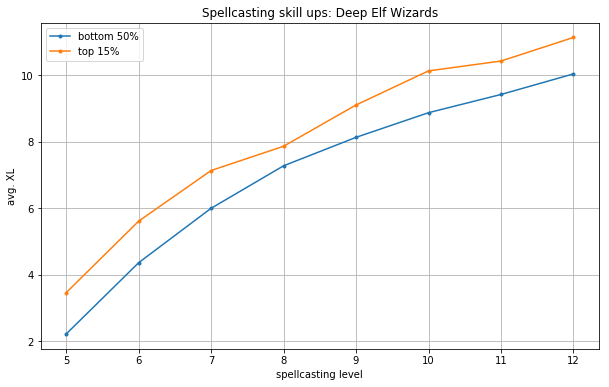

In [ ]:
sps = ['deep elf']
bgs = ['wizard']
ax = plot_progress(sps, bgs, max_skill=13);
ax.set_title("Spellcasting skill ups: Deep Elf Wizards")

Characters in the bottom-half consistently reach a given level of spellcasting a full player level before characters in the top 15%. 

(Note that skill level is on the x-axis and player level on the y-axis. The transpose seems more natural, but this arrangement better reflects the underlying data. Morguefiles give the player level (XL) when each skill levels up, not the other way around. Technically each point should be read as "of DEWz characters that reached Spellcasting level x, the average XL at which they did so was y")

Let's throw together a bunch of popular caster species and backgrounds, to make sure this isn't a fluke specific to DEWz's. This'll also give us a big enough sample to extend the comparison to late-game.

In [ ]:
sps = {'deep elf', 'human', 'tengu', 'octopode', 'high elf'}
bgs = {'wizard', 'conjurer', 'fire elementalist', 'air elementalist', 
      'earth elementalist', 'ice elementalist', 'summoner'}
print "Considering all species/bg combos in {} x {}...".format(sps, bgs)
plot_progress(sps, bgs);

Considering all species/bg combos in set(['octopode', 'tengu', 'high elf', 'deep elf', 'human']) x set(['summoner', 'wizard', 'earth elementalist', 'conjurer', 'ice elementalist', 'fire elementalist', 'air elementalist'])...


In [ ]:
Wow! The gap just gets wider. Around the mid-to-late game, the bottom half are hitting spellcasting milestones 3-4 levels earlier than their high-winrate counterparts. That's huge!

**Verdict**

In [ ]:
Image(url='/assets/dcss/trap.png')

## Octopodes

In an [earlier post](/blog/dcss_species) analyzing species, I speculated that Octopodes' last-place win-rate might be because they're attractive to newbs. (Granted, they're a weird species with a very impactful limitation - no armour. But they're easy to grok, and the promise of getting to wear 8 rings is a cool hook.)

In [ ]:
def plot_species_pickrate(species):
    pickrate = (
        g[g['species']==species].groupby('quantile').size() 
        / 
        g.groupby('quantile').size()
    )
    ax = pickrate.plot.bar(figsize=FS)
    ax.grid(axis='y')
    ax.set_ylabel('Pick rate')
    ax.set_yticklabels('{:.1f}%'.format(100*y) for y in ax.get_yticks())
    ax.set_title("{} pick rate by quantile".format(species))
    return ax

plot_species_pickrate('octopode');

This is vaguely consistent with my hypothesis, but the difference from one end of the player base to the other is not huge, and the second most prestigious group has the second-highest pick rate.

In [ ]:
Image(url='/assets/dcss/notatrap.png')

I also speculated that Deep Dwarves may have the highest win rate of all species because they're the opposite of a newbie trap. They're a mechanically tricky species with a very intimidating constraint (no HP regeneration). Maybe only veterans are confident enough to play them.


In [ ]:
plot_species_pickrate('deep dwarf');

Well that's much more compelling. 

One interesting thing to note is that the players in the bottom quarter here are actually not likely to be newbs in the literal sense. 

There are virtually no wins in the bottom half. What separates the two bottom quarters is the size of their track record of failure. Players in the bottom quarter have all played 250+ games without a win. Players in the next quarter have a mere streak of 50-250 losses (or, rarely, a single win out of >1,000 games).

So it might be more correct to say that this suggests that successful players are attracted to deep dwarves and unsuccessful players (not necessarily *inexperienced* players) are uninterested in DDs.

## Early rune grabs

A couple months ago I introduced my boyfriend to DCSS, and it's been a lot of fun watching him progress. He's committed to not reading spoilers until he's won a game, so he's a great subject of observation when it comes to newbie traps. 

He recently got his [first rune](http://crawl.berotato.org/crawl/morgue/falsifian/falsifian.txt) ever. How he managed it at level 15, I have no idea. I've been playing a Deep Elf in parallel with his, and I picked up my first rune at level 18, after having cleared the Dungeon, the Orcish Mines, and the first 3 floors of the other S-branch. He cleared up to D:9, cleared the Lair, then waltzed straight down to the bottom of the Swamp.

I would guess that this is not an uncommon mistake. When you get to a staircase, the natural thing is to go down it. Incrementally clearing and backtracking isn't an obvious strategy. And the spike in danger of the final floor of a branch is something you either read about, or learn from painful experience.

([This tavern post](https://crawl.develz.org/tavern/viewtopic.php?f=17&t=19840) has a cool idea about restructuring the dungeon to make this less of a trap.)

In [ ]:
r = store['runes']
r = r.merge(g['quantile'].to_frame(), left_on='gid', right_index=True)

In [ ]:
quant_groups = [['0-25%', '25-50%'], ['85-95%', '95-100%']]
quant_labels = ['bottom 50%', 'top 15%']
def quant_group(label):
    q = r.loc[label, 'quantile']
    if q in quant_groups[0]:
        return 0
    elif q in quant_groups[1]:
        return 1

def plot_rune_levels(r, order=1, ax=None):
    rune_levels = r[r['order']==order].groupby(['xl', quant_group]).size()\
        .reset_index(level=1)\
        .pivot(columns='level_1', values=0)\
        .fillna(0)
    # Normalize
    for col in [0, 1]:
        rune_levels[col] = rune_levels[col] / rune_levels[col].sum()
    rune_levels.rename(columns={0: quant_labels[0], 1: quant_labels[1]}, inplace=1)
    rune_levels.columns.name = 'quantile'
    ax = rune_levels.plot.bar(figsize=FS, stacked=0, label=quant_labels, ax=ax)
    ax.set_title("Level when snatching rune # {}".format(order))
    return ax

plot_rune_levels(r);

Level 15! Damn falsifian, you were really on the scary side of the bell curve.

XL isn't a great universal scale for how advanced a character is, because of differences in XP aptitudes between species. Let's generate the same graph from just deep elf games as a sanity check.

In [ ]:
deepgids = g[g['species']=='deep elf'].index
ax = plot_rune_levels(
    r[r['gid'].isin(deepgids)]
);

Still quite a clear difference! 

Let's add runes 2 and 3 to the mix.

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(12,17), sharex=True)
for i, ax in zip(range(1,4), axes.flatten()):
    plot_rune_levels(r, order=i, ax=ax)

Hold your horses, noobs!

**Verdict**

In [ ]:
Image(url='/assets/dcss/trap.png')